<a href="https://colab.research.google.com/github/GRACEWELLTECH/BreakFast-Menu/blob/master/Covid_image_classification_customized_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explore the evaluation of COVID-19 DATASET


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
base_dir = '/content/drive/My Drive/covid19data'

'''train_dir = os.path.join(base_dir, 'train')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'CT_COVID')

train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])'''

"train_dir = os.path.join(base_dir, 'train')\n\n# Directory with our training cat pictures\ntrain_cats_dir = os.path.join(train_dir, 'CT_COVID')\n\ntrain_cat_fnames = os.listdir(train_cats_dir)\nprint(train_cat_fnames[:10])"

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'CT_COVID')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'CT_NonCOVID')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'CT_COVID')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'CT_NonCOVID')

In [0]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['PIIS0140673620303603%6.png', '2020.03.10.20032136-p34-118_1%1.png', '2020.03.12.20027185-p8-217.png', '2020.03.04.20031039-p23-97_2%2.png', 'Comparison-of-different-samples-for-2019-novel-cor_2020_International-Journa-p2-21%4.png', 'bmj.m606.full-p4-22%4.png', '2020.03.12.20034686-p17-91-5.png', '2020.03.13.20035212-p23-155.png', '2020.03.18.20038125-p15-54-2.png', '2020.03.12.20034686-p17-91-1.png']
['102.png', '1029.png', '103.png', '1030.png', '104.png', '1046.png', '1047.png', '1048.png', '1049.png', '1050.png']


Let's find out the total number of images in the `train` and `validation` directories:

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 331
total training dog images: 84
total validation cat images: 20
total validation dog images: 8


In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [0]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model architecture:

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 415 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=8,  # 1000 images = batch_size * steps
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
10/10 - 70s - loss: 0.8855 - acc: 0.7400 - val_loss: 0.6321 - val_acc: 0.7143
Epoch 2/15
10/10 - 60s - loss: 0.5236 - acc: 0.8100 - val_loss: 0.5610 - val_acc: 0.7054
Epoch 3/15
10/10 - 6s - loss: 0.3751 - acc: 0.8410 - val_loss: 0.7652 - val_acc: 0.7143
Epoch 4/15
10/10 - 6s - loss: 0.3553 - acc: 0.8650 - val_loss: 0.4945 - val_acc: 0.8036
Epoch 5/15
10/10 - 6s - loss: 0.2955 - acc: 0.8872 - val_loss: 0.7674 - val_acc: 0.7143
Epoch 6/15
10/10 - 6s - loss: 0.2992 - acc: 0.8800 - val_loss: 0.9046 - val_acc: 0.7054
Epoch 7/15
10/10 - 6s - loss: 0.2041 - acc: 0.9385 - val_loss: 1.3622 - val_acc: 0.7143
Epoch 8/15
10/10 - 6s - loss: 0.3738 - acc: 0.8750 - val_loss: 0.4063 - val_acc: 0.8125
Epoch 9/15
10/10 - 6s - loss: 0.2079 - acc: 0.9026 - val_loss: 0.4314 - val_acc: 0.8214
Epoch 10/15
10/10 - 6s - loss: 0.2116 - acc: 0.9250 - val_loss: 1.1422 - val_acc: 0.6875
Epoch 11/15
10/10 - 6s - loss: 0.1403 - a

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

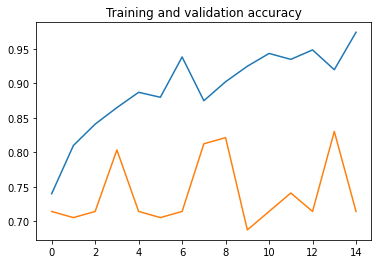

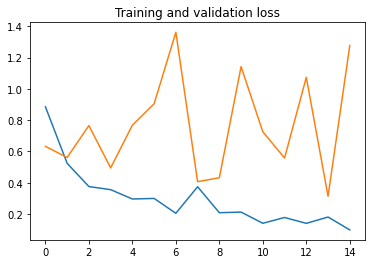

In [0]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)